# Model Evaluation for Cats vs Dogs
This notebook evaluates trained models and prints accuracy and confusion matrix tables.

In [1]:
import os
import csv
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset, concatenate_datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


c:\Users\stiva001\AppData\Local\anaconda3\envs\ml_class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

Define parameters for dataset location, model paths, and device configuration.

In [2]:
# constants matching notebooks
IMG_DIM = (128, 128)
IMG_SIZE_VIT = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Datasets

Define the dataset paths and load the test dataset.
Also the test dataset dataset for evaluation.

In [3]:
class HFDatasetEval(Dataset):
    def __init__(self, hf_dataset, transform=None, return_tensor_label=False):
        self.ds = hf_dataset
        self.transform = transform
        self.return_tensor_label = return_tensor_label

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(item['labels'])
        if self.return_tensor_label:
            return img, torch.tensor(label, dtype=torch.float32)
        return img, label

In [4]:
def prepare_hf_subset(n_per_class=500):
    from datasets import concatenate_datasets

    # Load dataset (this will download if not present)
    ds_full = load_dataset("microsoft/cats_vs_dogs")['train']

    # Select 500 cats and 500 dogs
    cats = ds_full.filter(lambda x: x['labels'] == 0)
    dogs = ds_full.filter(lambda x: x['labels'] == 1)

    # select the last 500 examples from each split 
    cats = cats.select(range(max(len(cats) - n_per_class, 0), len(cats)))
    dogs = dogs.select(range(max(len(dogs) - n_per_class, 0), len(dogs)))

    test_ds = concatenate_datasets([cats, dogs])

    return test_ds

### Models Architectures

Define functions to load different model architectures: Basic CNN, Transfer Learning with VGG16 and ViT

In [5]:
# Model classes mirroring the notebooks (minimal)
class BasicCNN(nn.Module):
    def __init__(self, img_dim=IMG_DIM):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        flattened = 128 * (img_dim[0]//8) * (img_dim[1]//8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)

In [6]:
class AugCNN(BasicCNN):
    # same architecture as BasicCNN for evaluation
    pass

In [7]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg_features = vgg.features

# compute feature dimension by passing a dummy
with torch.no_grad():
    dummy = torch.zeros(1, 3, IMG_DIM[0], IMG_DIM[1])
    feat = vgg_features(dummy)
    feat_shape = feat.shape
    flattened_dim = feat_shape[1] * feat_shape[2] * feat_shape[3]

print('Bottleneck feature shape:', feat_shape, 'flattened dim:', flattened_dim)

class BottleneckClassifier(nn.Module):
    def __init__(self, flattened_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x).squeeze(1)

class TransferModel(nn.Module):
    def __init__(self, vgg_features, classifier):
        super().__init__()
        self.vgg_features = vgg_features
        self.classifier = classifier

    def forward(self, x):
        with torch.no_grad():
            x = self.vgg_features(x)
        return self.classifier(x)


def load_basic_model(path):
    model = BasicCNN().to(DEVICE)
    state = torch.load(path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state)
    model.eval()
    return model

Bottleneck feature shape: torch.Size([1, 512, 4, 4]) flattened dim: 8192


##### Methods to load the models

Each function loads a specific model architecture and its weights from a given path.

In [8]:
def load_aug_model(path):
    model = AugCNN().to(DEVICE)
    state = torch.load(path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state)
    model.eval()
    return model

In [9]:
def load_transfer_model(path, img_dim=IMG_DIM):
    # construct vgg features and classifier matching the training script
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    vgg_features = vgg.features
    for p in vgg_features.parameters():
        p.requires_grad = False
    # compute flattened dim
    with torch.no_grad():
        dummy = torch.zeros(1, 3, img_dim[0], img_dim[1])
        feat = vgg_features(dummy)
        flattened_dim = int(feat.numel() / feat.shape[0])
    classifier = BottleneckClassifier(flattened_dim)
    model = TransferModel(vgg_features, classifier).to(DEVICE)
    state = torch.load(path, map_location=DEVICE, weights_only=True)
    # Try loading into classifier first (not the whole model)
    try:
        classifier.load_state_dict(state)
        model.eval()
        return model
    except Exception:
        # fallback: try load into full model
        model.load_state_dict(state)
        model.eval()
        return model

In [10]:
def load_vit_model(path):
    # Use torchvision's pretrained ViT (vit_b_32) from ImageNet
    from torchvision import models as tv_models

    weights = tv_models.ViT_B_32_Weights.IMAGENET1K_V1
    model = tv_models.vit_b_32(weights=weights).to(DEVICE)

    # get the size of last attention layer inside the ViT
    in_features = model.heads.head.in_features

    # create the new classification layer
    model.heads = nn.Sequential(
        nn.Linear(in_features, 2),
        nn.Sigmoid())

    model.to(DEVICE)
    state = torch.load(path, map_location=DEVICE, weights_only=True)
    try:
        model.load_state_dict(state)
    except Exception:
        # if state contains only head weights or different keys, ignore strict
        model.load_state_dict(state, strict=False)
    model.eval()
    return model


#### Evualtion Function

Define a function to evaluate a model on the test dataset and compute various metrics.

In [11]:
def evaluate_model(model, dataloader, model_type='binary'):
    preds = []
    probs = []
    labels = []

    for batch in tqdm(dataloader, desc='Evaluating'):
        imgs, labs = batch
        imgs = imgs.to(DEVICE)
        if isinstance(labs, torch.Tensor):
            labs_t = labs
        else:
            labs_t = torch.tensor(labs)
        labels.extend([int(x) for x in labs_t])
        with torch.no_grad():
            out = model(imgs)
            if model_type == 'binary':
                # output is single sigmoid or probability
                if out.dim() == 0 or out.shape[-1] == 1:
                    prob = out.detach().cpu().numpy().reshape(-1)
                else:
                    prob = out.detach().cpu().numpy().reshape(-1)
                pred = (prob > 0.5).astype(int)
                probs.extend(list(prob))
                preds.extend(list(pred))
            else:
                # multiclass logits
                logits = out.detach().cpu().numpy()
                prob = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
                pred = np.argmax(prob, axis=1)
                probs.extend(list(prob[:, 1]))
                preds.extend(list(pred))

    # compute metrics
    y_true = np.array(labels)
    y_pred = np.array(preds)
    y_prob = np.array(probs)
    results = {}
    results['accuracy'] = float(accuracy_score(y_true, y_pred))
    results['precision'] = float(precision_score(y_true, y_pred, zero_division=0))
    results['recall'] = float(recall_score(y_true, y_pred, zero_division=0))
    results['f1'] = float(f1_score(y_true, y_pred, zero_division=0))
    try:
        results['roc_auc'] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        results['roc_auc'] = None
    results['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return results

In [12]:
print('Device:', DEVICE)
print('Preparing dataset...')
test_ds = prepare_hf_subset(n_per_class=500)

# Transforms for CNNs
transform_cnn = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])
transform_vit = transforms.Compose([
    transforms.Resize((IMG_SIZE_VIT, IMG_SIZE_VIT)),
    transforms.ToTensor(),
])

test_dataset_cnn = HFDatasetEval(test_ds, transform=transform_cnn, return_tensor_label=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset_vit = HFDatasetEval(test_ds, transform=transform_vit, return_tensor_label=False)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# models and their weight paths (relative to repository root)
model_info = [
    ('basic_cnn', 'CTRL_OA_basic_cnn_drop_pytorch_hf.pth', 'binary', 'cnn'),
    ('aug_cnn', 'CTRL_OA_cnn_img_aug_pytorch.pth', 'binary', 'cnn'),
    ('transfer', 'CTRL_OA_tlearn_basic_cnn_pytorch.pth', 'binary', 'transfer'),
    ('vit', 'ViT_model_pytorch.pt', 'multiclass', 'vit'),
]

Device: cuda
Preparing dataset...


Filter: 100%|██████████| 23410/23410 [00:14<00:00, 1581.57 examples/s]


In [13]:
import os
import sys
import shutil
import glob
from pathlib import Path
import subprocess

# Download model weight files from a Google Drive folder using gdown.
# This cell expects `model_info` to be defined elsewhere in the notebook (it's defined in a later cell).
# If model_info is not available, a fallback list is used based on the filenames you provided.

# ensure gdown is available
try:
    import gdown
except Exception:
    print("gdown not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])

# folder url (from your message)
folder_url = "https://drive.google.com/drive/folders/1gG2RvIwV-gIv0rZgrcmj_tOtWDzpx_FS?usp=drive_link"

# target filenames (prefer using model_info defined elsewhere in the notebook)
if 'model_info' in globals():
    target_fnames = [entry[1] for entry in model_info]
else:
    # fallback list (matches the list you provided)
    target_fnames = [
        'CTRL_OA_basic_cnn_drop_pytorch_hf.pth',
        'CTRL_OA_cnn_img_aug_pytorch.pth',
        'CTRL_OA_tlearn_basic_cnn_pytorch.pth',
        'ViT_model_pytorch.pt',
    ]

cwd = Path.cwd()
temp_dir = cwd / "gdrive_models_temp"
temp_dir.mkdir(exist_ok=True)

# determine which files are missing locally
missing = [f for f in target_fnames if not (cwd / f).exists()]
if not missing:
    print("All target files already exist in the current directory. Nothing to download.")
else:
    print("Missing files:", missing)
    print("Downloading folder contents to temporary directory (this may download extra files)...")
    try:
        # download entire folder into temp_dir
        # gdown.download_folder will create files under temp_dir
        gdown.download_folder(folder_url, output=str(temp_dir), quiet=False, use_cookies=False)
    except Exception as e:
        print("Error downloading folder with gdown:", e)
    else:
        # search recursively for matching files and move them to cwd
        found = []
        for fname in missing:
            matches = list(temp_dir.rglob(fname))
            if matches:
                # take the first match
                src = matches[0]
                dest = cwd / fname
                shutil.move(str(src), str(dest))
                found.append(fname)
                print(f"Moved {fname} -> {dest}")
            else:
                print(f"File not found in downloaded folder: {fname}")

        if found:
            print("Downloaded and moved files:", found)

# cleanup temporary download directory if empty or exists
try:
    # if directory exists and is empty, remove it; if contains other files, leave it
    if temp_dir.exists():
        remaining = list(temp_dir.rglob('*'))
        if not remaining:
            temp_dir.rmdir()
        else:
            print(f"Temporary download directory kept at {temp_dir} (contains other files).")
except Exception:
    pass

Retrieving folder contents


Missing files: ['CTRL_OA_basic_cnn_drop_pytorch_hf.pth', 'CTRL_OA_cnn_img_aug_pytorch.pth', 'CTRL_OA_tlearn_basic_cnn_pytorch.pth', 'ViT_model_pytorch.pt']
Processing file 1rnPQG4InLxJmRhPmpOj8tEUYchpg2I2F CTRL_OA_basic_cnn_drop_pytorch_hf.pth
Processing file 15dAYD16vcuYpEif400w-77tJFNNUzpd4 CTRL_OA_cnn_img_aug_pytorch.pth
Processing file 1nugCw-x3a2C2Uz_cJeda227veKayrPk3 CTRL_OA_tlearn_basic_cnn_pytorch.pth
Processing file 1T_bCvGgXsWf9Tpj9a9I9L9he_eVPbm2- CTRL_OA_tlearn_finetune_img_aug_cnn_pytorch.pth
Processing file 1shC-CD6KUwFo34-KbhaziqilEUYn5lbE ViT_model_pytorch.pt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1rnPQG4InLxJmRhPmpOj8tEUYchpg2I2F
From (redirected): https://drive.google.com/uc?id=1rnPQG4InLxJmRhPmpOj8tEUYchpg2I2F&confirm=t&uuid=c2473ae0-00cd-4789-87de-cbdaf0763dcc
To: c:\WUR\transfer-learning-Felipe-Moura\computer_vision\gdrive_models_temp\CTRL_OA_basic_cnn_drop_pytorch_hf.pth
100%|██████████| 67.5M/67.5M [00:30<00:00, 2.19MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=15dAYD16vcuYpEif400w-77tJFNNUzpd4
From (redirected): https://drive.google.com/uc?id=15dAYD16vcuYpEif400w-77tJFNNUzpd4&confirm=t&uuid=01a5139a-a597-406f-beb7-92a6f42bc9f7
To: c:\WUR\transfer-learning-Felipe-Moura\computer_vision\gdrive_models_temp\CTRL_OA_cnn_img_aug_pytorch.pth
100%|██████████| 67.5M/67.5M [00:31<00:00, 2.16MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nugCw-x3a2C2Uz_cJeda227veKayrPk3
To: c:\WUR\tr

Moved CTRL_OA_basic_cnn_drop_pytorch_hf.pth -> c:\WUR\transfer-learning-Felipe-Moura\computer_vision\CTRL_OA_basic_cnn_drop_pytorch_hf.pth
Moved CTRL_OA_cnn_img_aug_pytorch.pth -> c:\WUR\transfer-learning-Felipe-Moura\computer_vision\CTRL_OA_cnn_img_aug_pytorch.pth
Moved CTRL_OA_tlearn_basic_cnn_pytorch.pth -> c:\WUR\transfer-learning-Felipe-Moura\computer_vision\CTRL_OA_tlearn_basic_cnn_pytorch.pth
Moved ViT_model_pytorch.pt -> c:\WUR\transfer-learning-Felipe-Moura\computer_vision\ViT_model_pytorch.pt
Downloaded and moved files: ['CTRL_OA_basic_cnn_drop_pytorch_hf.pth', 'CTRL_OA_cnn_img_aug_pytorch.pth', 'CTRL_OA_tlearn_basic_cnn_pytorch.pth', 'ViT_model_pytorch.pt']
Temporary download directory kept at c:\WUR\transfer-learning-Felipe-Moura\computer_vision\gdrive_models_temp (contains other files).



Download completed


#### Evaluate Models

Loop for each model, load it, evaluate it, and store the results.

In [14]:
results = []
for name, path, mtype, arch in model_info:
    fullpath = os.path.join(path)
    print('\nEvaluating', name, 'from', fullpath)
    if not os.path.exists(fullpath):
        print('  Weight file not found:', fullpath)
        continue
    try:
        if name == 'basic_cnn':
            model = load_basic_model(fullpath)
            loader = test_loader_cnn
            res = evaluate_model(model, loader, model_type='binary')
        elif name == 'aug_cnn':
            model = load_aug_model(fullpath)
            loader = test_loader_cnn
            res = evaluate_model(model, loader, model_type='binary')
        elif name == 'transfer':
            model = load_transfer_model(fullpath)
            loader = test_loader_cnn
            res = evaluate_model(model, loader, model_type='binary')
        elif name == 'vit':
            model = load_vit_model(fullpath)
            loader = test_loader_vit
            res = evaluate_model(model, loader, model_type='multiclass')
        else:
            print('Unknown model', name)
            continue
    except Exception as e:
        print('  Error loading/evaluating', name, e)
        continue

    res_row = {'model': name, 'path': fullpath}
    res_row.update({k: v for k, v in res.items() if k != 'confusion_matrix'})
    res_row['confusion_matrix'] = str(res['confusion_matrix'])
    results.append(res_row)
    print('  Results:', res_row)


Evaluating basic_cnn from CTRL_OA_basic_cnn_drop_pytorch_hf.pth


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]


  Results: {'model': 'basic_cnn', 'path': 'CTRL_OA_basic_cnn_drop_pytorch_hf.pth', 'accuracy': 0.61, 'precision': 0.6082677165354331, 'recall': 0.618, 'f1': 0.6130952380952381, 'roc_auc': 0.653662, 'confusion_matrix': '[[301, 199], [191, 309]]'}

Evaluating aug_cnn from CTRL_OA_cnn_img_aug_pytorch.pth


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 23.10it/s]


  Results: {'model': 'aug_cnn', 'path': 'CTRL_OA_cnn_img_aug_pytorch.pth', 'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666, 'roc_auc': 0.5, 'confusion_matrix': '[[0, 500], [0, 500]]'}

Evaluating transfer from CTRL_OA_tlearn_basic_cnn_pytorch.pth


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 16.55it/s]


  Results: {'model': 'transfer', 'path': 'CTRL_OA_tlearn_basic_cnn_pytorch.pth', 'accuracy': 0.931, 'precision': 0.9443298969072165, 'recall': 0.916, 'f1': 0.9299492385786802, 'roc_auc': 0.9781159999999999, 'confusion_matrix': '[[473, 27], [42, 458]]'}

Evaluating vit from ViT_model_pytorch.pt


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 13.02it/s]

  Results: {'model': 'vit', 'path': 'ViT_model_pytorch.pt', 'accuracy': 0.983, 'precision': 0.9763313609467456, 'recall': 0.99, 'f1': 0.9831181727904668, 'roc_auc': 0.9981519999999999, 'confusion_matrix': '[[488, 12], [5, 495]]'}


#### Save Results

Save the evaluation results to a CSV file for further analysis.

In [15]:
# save CSV
out_csv = os.path.join('evaluation_results.csv')
if results:
    keys = ['model', 'path', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'confusion_matrix']
    with open(out_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        for r in results:
            writer.writerow(r)
    print('\nSaved evaluation results to', out_csv)
else:
    print('\nNo results to save.')


Saved evaluation results to evaluation_results.csv


### Plot the results

Compare the results visually using plots.
Starting with accuracy and confusion matrix of each model.


Model Metrics:
    Model  Accuracy       F1  Precision  Recall
basic_cnn     0.610 0.613095   0.608268   0.618
  aug_cnn     0.500 0.666667   0.500000   1.000
 transfer     0.931 0.929949   0.944330   0.916
      vit     0.983 0.983118   0.976331   0.990


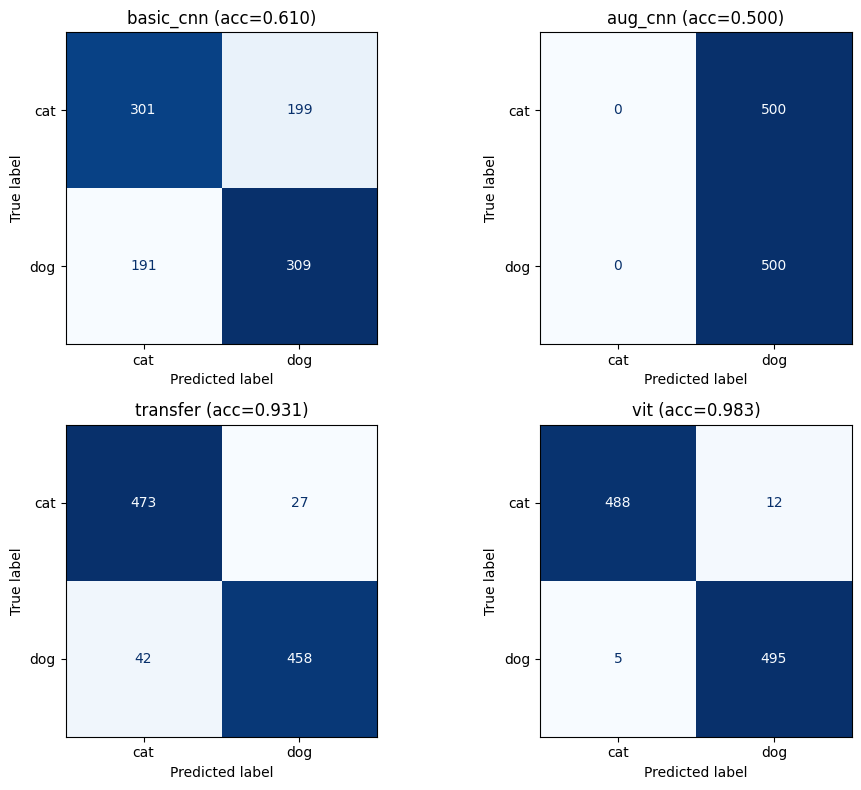

In [16]:
# Prepare table with accuracy, f1, precision, recall
table_data = [
    (r['model'], r['accuracy'], r['f1'], r['precision'], r['recall']) for r in results
]

import pandas as pd

df_metrics = pd.DataFrame(table_data, columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])
print("\nModel Metrics:")
print(df_metrics.to_string(index=False))

# plot all confusion matrices in a single 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(results):
        r = results[i]
        cm = eval(r['confusion_matrix']) if isinstance(r['confusion_matrix'], str) else r['confusion_matrix']
        cm_arr = np.array(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_arr, display_labels=['cat', 'dog'])
        disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
        ax.set_title(f"{r['model']} (acc={r.get('accuracy', 0):.3f})")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualization Layers Activations

The following code visualizes the activations of intermediate layers for a sample image from the cats vs dogs dataset.
Is demonstrat how the model processes the image at different stages.

In [17]:
# --- CNN Activation Visualization for a Sample (All Models) ---
print("\nVisualizing activations for a sample image from the test set (all CNN models)...")

import matplotlib.pyplot as plt

sample_img, sample_label = test_dataset_cnn[0]
sample_img_tensor = sample_img.unsqueeze(0).to(DEVICE)

cnn_models = [
    ("BasicCNN", load_basic_model, os.path.join('CTRL_OA_basic_cnn_drop_pytorch_hf.pth')),
    ("AugCNN", load_aug_model, os.path.join('CTRL_OA_cnn_img_aug_pytorch.pth')),
    ("TransferCNN", load_transfer_model, os.path.join('CTRL_OA_tlearn_basic_cnn_pytorch.pth')),
]


Visualizing activations for a sample image from the test set (all CNN models)...



BasicCNN activations:
Layer 1 activation shape: torch.Size([1, 16, 128, 128])
Layer 2 activation shape: torch.Size([1, 64, 64, 64])
Layer 3 activation shape: torch.Size([1, 128, 32, 32])


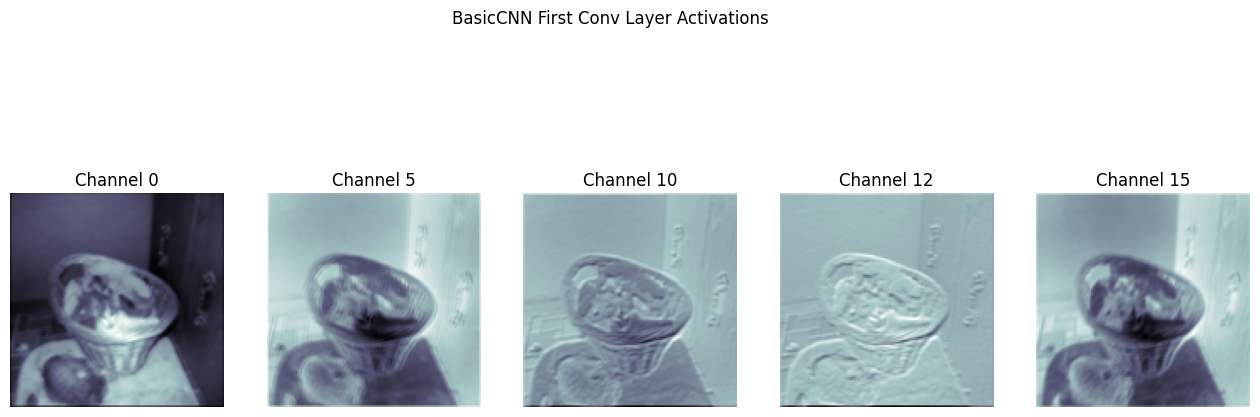


AugCNN activations:
Layer 1 activation shape: torch.Size([1, 16, 128, 128])
Layer 2 activation shape: torch.Size([1, 64, 64, 64])
Layer 3 activation shape: torch.Size([1, 128, 32, 32])


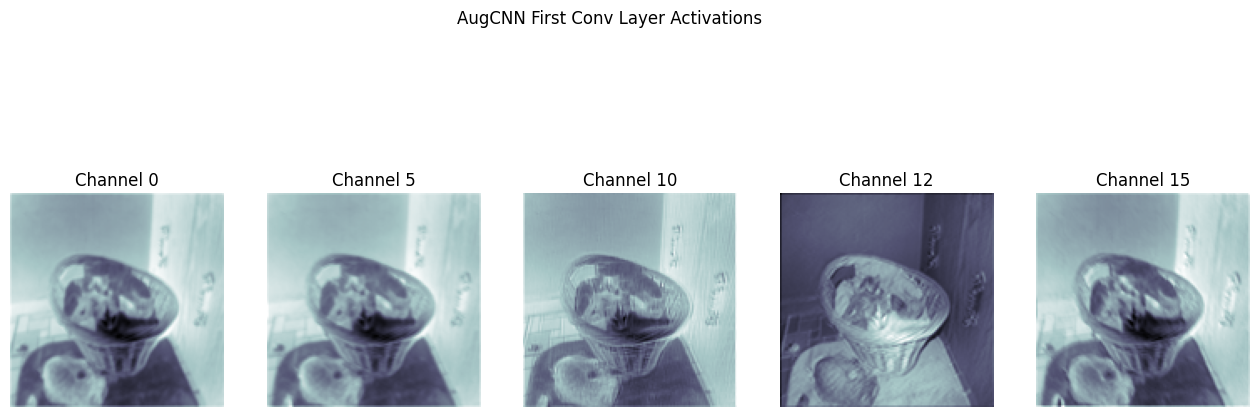


TransferCNN activations:
Layer 1 activation shape: torch.Size([1, 64, 128, 128])
Layer 2 activation shape: torch.Size([1, 64, 128, 128])
Layer 3 activation shape: torch.Size([1, 128, 64, 64])


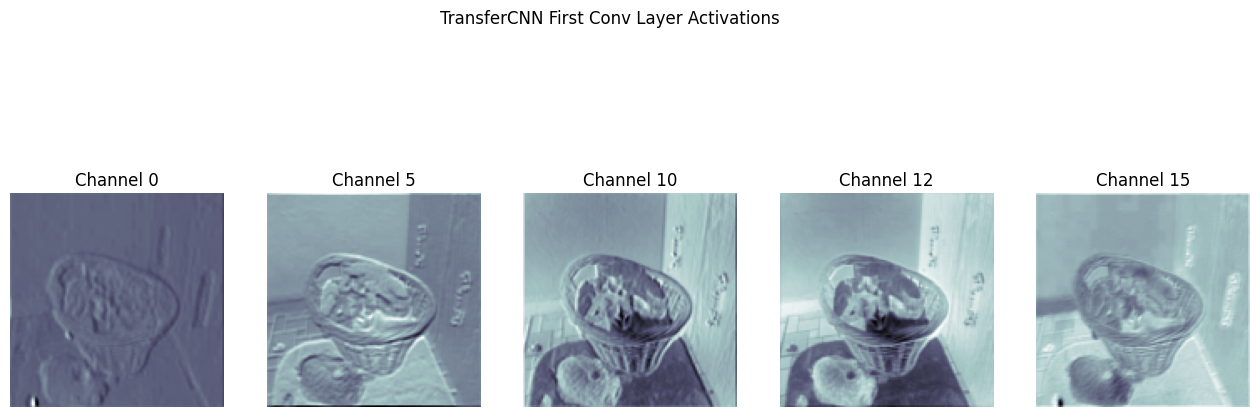

In [18]:
for model_name, loader_fn, model_path in cnn_models:
    if not os.path.exists(model_path):
        print(f"{model_name} weights not found at {model_path}, skipping activation visualization.")
        continue
    print(f"\n{model_name} activations:")
    if model_name == "TransferCNN":
        model = loader_fn(model_path)
        # For transfer model, use model.vgg_features
        x = sample_img_tensor
        activations = []
        for i, layer in enumerate(model.vgg_features):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                activations.append(x.detach().cpu())
            if len(activations) == 3:
                break
    else:
        model = loader_fn(model_path)
        x = sample_img_tensor
        activations = []
        for i, layer in enumerate(model.features):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                activations.append(x.detach().cpu())
            if len(activations) == 3:
                break
    for idx, act in enumerate(activations):
        print(f"Layer {idx+1} activation shape: {act.shape}")
    act = activations[0]
    fig, ax = plt.subplots(1, 5, figsize=(16, 6))
    for i, channel in enumerate([0, 5, 10, 12, 15]):
        if channel < act.shape[1]:
            ax[i].imshow(act[0, channel, :, :], cmap='bone')
            ax[i].set_title(f'Channel {channel}')
            ax[i].axis('off')
        else:
            ax[i].axis('off')
    plt.suptitle(f'{model_name} First Conv Layer Activations')
    plt.show()